In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from tqdm import trange

In [111]:

def portfolio_var(
        weigths: np.ndarray[float], 
        sigma: np.ndarray[float]
        ) -> float:
    
    return weigths.T @ sigma @ weigths

def MC_optim_portfolio(
        mean_returns: np.ndarray[float], 
        cov_matrix: np.ndarray[float],
        Nsim: int,
        ) -> np.ndarray[float]:
    
    max_sharpe: float = 0.
    opt_weights = np.array([])
    weights = np.random.dirichlet(np.ones(len(mean_returns)), size=Nsim)
    for i in range(Nsim):
        W = weights[i]
        mean = (mean_returns * W).mean() # Expected portfolio return 
        std = np.sqrt(portfolio_var(W, cov_matrix)) # Portfolio standard deviation
        sharpe = mean/std

        if sharpe > max_sharpe: # Check if sharpe ratio is the highest
            max_sharpe = sharpe
            opt_weights = W

    return opt_weights, max_sharpe


100%|██████████| 30/30 [01:20<00:00,  2.67s/it]


<AxesSubplot:>

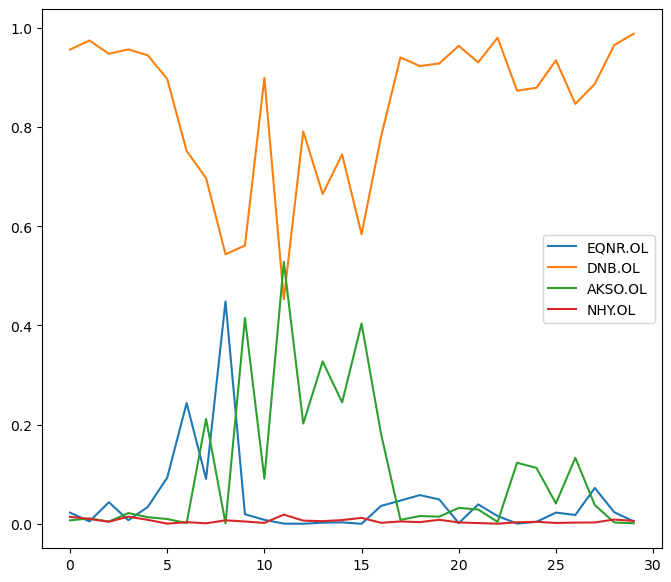

In [114]:

tickers: list[str] = ['EQNR.OL', 'DNB.OL', 'AKSO.OL', 'NHY.OL']
tic_names: list[str] = ['Equinor ASA', 'DNB ASA', 'Aker Solutions ASA', 'Norsk Hydro ASA']

closing_price = yf.download(tickers, period='5Y', ignore_tz=True, progress=False)['Adj Close']
log_returns = np.log(closing_price/closing_price.shift()).dropna()

mean_returns = np.array(log_returns.mean())
cov_matrix = np.array(log_returns.cov())

days = 30

res_matrix = np.zeros((days, len(tickers)))

rolling_mean = log_returns.rolling(days).sum().iloc[-days:]

for i in trange(days):

    mean_returns = rolling_mean.iloc[i] * 252

    cov_matrix = log_returns.iloc[-2*days + i:-days+i].cov().to_numpy() * 252 

    OW, HS = MC_optim_portfolio(mean_returns, cov_matrix, 10000)
    res_matrix[i, :] = OW

results = pd.DataFrame(res_matrix, columns=tickers)

fig, ax = plt.subplots(figsize=(8, 7))

results.plot(ax= ax)